In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tvDatafeed import TvDatafeed, Interval
from tqdm import tqdm
from config.account_info import *

tv = TvDatafeed(USERNAME, PASSWARD)

# 이미 주어진다고 한 것
MONTH_CODE = {
    1:"F", 2:"G", 3:"H", 4:"J", 5:"K", 6:"M",
    7:"N", 8:"Q", 9:"U", 10:"V", 11:"X", 12:"Z"
}
CODE_TO_MONTH = {v: k for k, v in MONTH_CODE.items()}

def get_futures_symbol_for_fomc(meeting_date: pd.Timestamp) -> str:
    """
    FOMC 회의 날짜로부터 해당 월의 ZQ 선물 심볼을 생성합니다.
    예: 2025-03-18 → ZQH2025
    """
    if not isinstance(meeting_date, pd.Timestamp):
        meeting_date = pd.to_datetime(meeting_date)

    year = meeting_date.year
    month = meeting_date.month
    mcode = MONTH_CODE[month]
    return f"ZQ{mcode}{year}"

def get_next_futures_symbol(meeting_date: pd.Timestamp) -> str:
    """
    FOMC 회의가 있는 달의 '다음 달' ZQ 선물 심볼을 생성합니다.
    예: 2025-03-18 → ZQJ2025 (4월물)
        2025-12-10 → ZQF2026 (다음 해 1월물)
    """
    if not isinstance(meeting_date, pd.Timestamp):
        meeting_date = pd.to_datetime(meeting_date)

    year = meeting_date.year
    month = meeting_date.month
    if month == 12:
        year += 1
        month = 1
    else:
        month += 1
    mcode = MONTH_CODE[month]
    return f"ZQ{mcode}{year}"

def get_next_symbol_from_front(sym_front: str) -> str:
    """
    'ZQH2025' 같은 front 월물 심볼을 받아
    바로 다음 달 월물 심볼을 반환합니다.
    예: ZQX2025 (11월물) -> ZQZ2025 (12월물)
        ZQZ2025 (12월물) -> ZQF2026 (다음해 1월물)
    """
    # 형식: ZQ + month_code + year
    prefix = sym_front[:2]      # 'ZQ'
    mcode = sym_front[2]        # 'H', 'M', 'Z' ...
    year = int(sym_front[3:])   # '2025' -> 2025

    month = CODE_TO_MONTH[mcode]
    if month == 12:
        month_next = 1
        year_next = year + 1
    else:
        month_next = month + 1
        year_next = year

    mcode_next = MONTH_CODE[month_next]
    return f"{prefix}{mcode_next}{year_next}"

def get_front_symbol_for_meeting(meeting_date: pd.Timestamp) -> str:
    """
    단순 버전: 회의가 속한 '달'의 월물 = front 로 사용
    예: 2025-10-29 -> ZQV2025 (10월물)
    """
    if not isinstance(meeting_date, pd.Timestamp):
        meeting_date = pd.to_datetime(meeting_date)
    year = meeting_date.year
    month = meeting_date.month
    mcode = MONTH_CODE[month]
    return f"ZQ{mcode}{year}"

def front_weight_by_days_to_meeting(
    current_date: pd.Timestamp,
    meeting_date: pd.Timestamp,
    taper_start: int = 20,
    taper_end: int = 0,
    w_far: float = 1.0,
    w_near: float = 0.2,
) -> float:
    """
    회의일까지 남은 일수에 따라 front 월물에 줄 가중치 w를 계산합니다.

    - days_to_meeting >= taper_start → w = w_far (기본 1.0)
    - days_to_meeting <= taper_end   → w = w_near (기본 0.2)
    - 그 사이는 선형 보간
    """
    if not isinstance(current_date, pd.Timestamp):
        current_date = pd.to_datetime(current_date)
    if not isinstance(meeting_date, pd.Timestamp):
        meeting_date = pd.to_datetime(meeting_date)

    days_to_meeting = (meeting_date - current_date).days

    if days_to_meeting >= taper_start:
        return w_far
    elif days_to_meeting <= taper_end:
        return w_near
    else:
        # 선형 보간
        ratio = (days_to_meeting - taper_end) / (taper_start - taper_end)
        # days_to_meeting가 taper_start일 때 1, taper_end일 때 0이 되도록
        return w_near + (w_far - w_near) * ratio

# def _compute_month_weights(meeting_date: pd.Timestamp) -> tuple[int, int, int]:
#     """
#     단일 회의가 있는 월에 대해:
#     - month_start ~ meeting_date : 기존 금리
#     - meeting_date 다음 날 ~ month_end : 새 금리
#     로 가정했을 때 월평균 가중치용 일수 반환.
#     (모두 calendar day 기준)
#     """
#     meeting_date = pd.to_datetime(meeting_date)
#     month_start = meeting_date.replace(day=1)
#     month_end = (month_start + pd.offsets.MonthEnd(0))
#
#     # 월 전체 일수
#     N = (month_end - month_start).days + 1
#
#     # 회의 다음 날
#     first_after = meeting_date + pd.Timedelta(days=1)
#     if first_after > month_end:
#         # 이 달 안에 새 금리가 적용되지 않는 경우
#         N_before = N
#         N_after = 0
#     else:
#         N_before = (first_after - month_start).days
#         N_after = N - N_before
#
#     return N, N_before, N_after

def _compute_month_weights(meeting_date: pd.Timestamp) -> tuple[int, int, int]:
    """
    FOMC 회의가 속한 달의
    - 전체 일수 N
    - 회의 전 일수 N_before
    - 회의 후 일수 N_after
    를 calendar day 기준으로 계산합니다.
    """
    if not isinstance(meeting_date, pd.Timestamp):
        meeting_date = pd.to_datetime(meeting_date)

    month_start = meeting_date.replace(day=1)
    month_end = month_start + pd.offsets.MonthEnd(0)

    N = (month_end - month_start).days + 1
    N_before = (meeting_date - month_start).days
    N_after = N - N_before

    return N, N_before, N_after


def get_interest_probs_single_contract(
        futures_prices: pd.Series,
        effr_series: pd.Series,
        bp_moves: list[float] | np.ndarray,
        meeting_date: pd.Timestamp,
        expiry_date: pd.Timestamp | None = None,
        ma_window: int | None = 5,
        ma_apply_days: int | None = 20,
    ) -> pd.DataFrame:
    """
    단일 ZQ 월물 + EFFR + FOMC 회의 날짜를 이용해
    임의의 bp 시나리오들에 대한 확률 시계열을 계산합니다.

    특징
    ----
    - 월평균 금리 계산은 'meeting_date' 기준 (FedWatch 스타일)
    - 선물 가격 smoothing 은 '선물 만기(expiry_date)'까지 남은 일수 기준으로 적용

    Parameters
    ----------
    futures_prices : pd.Series
        index = DatetimeIndex, values = ZQ 선물 종가
    effr_series : pd.Series
        index = DatetimeIndex, values = EFFR (%, 예 3.83)
    bp_moves : list[float] or np.ndarray
        [-25, 0, 25] 등 FOMC에서의 변동 bp 시나리오
    meeting_date : pd.Timestamp
        해당 FOMC 회의 날짜 (월평균 가중치 계산용)
    expiry_date : pd.Timestamp or None
        이 선물 월물의 만기일.
        None 이면 futures_prices.index.max() 를 만기일로 근사.
    ma_window : int or None
        선물 가격 smoothing 에 사용할 이동평균 window (trailing).
        None 또는 1 이면 smoothing 사용 안 함.
    ma_apply_days : int or None
        만기일까지 남은 일수가 이 값 이하인 날짜들에만 smoothing 적용.
        예: 20 → 만기 20일 전부터 이동평균 사용.
        None 이면 전체 구간에 smoothing 적용.

    Returns
    -------
    pd.DataFrame
        index  = futures_prices.index
        columns:
            - 'price'      : 실제 확률 계산에 사용된 선물 가격 (raw or MA)
            - 'impl_rate'  : 100 - price
            - 'prob_[bp]'  : 각 bp 시나리오에 대한 확률 열 (예: prob_-25, prob_0, prob_25)
    """
    # 타입 정리
    if not isinstance(meeting_date, pd.Timestamp):
        meeting_date = pd.to_datetime(meeting_date)

    prices = futures_prices.sort_index()
    effr_aligned = effr_series.sort_index().reindex(prices.index, method="ffill")

    # 선물 만기일 설정 (없으면 가격 시계열 마지막 날짜로 근사)
    if expiry_date is None:
        expiry_date = prices.index.max()
    else:
        if not isinstance(expiry_date, pd.Timestamp):
            expiry_date = pd.to_datetime(expiry_date)

    # 월평균 가중치 (회의 기준)
    N, N_before, N_after = _compute_month_weights(meeting_date)

    # bp 시나리오 설정
    bp_moves = np.asarray(bp_moves, dtype=float)
    delta_bp = bp_moves / 100.0   # 25bp -> 0.25

    # 선물 가격 rolling mean (전체 시리즈 기준)
    if ma_window is not None and ma_window > 1:
        prices_ma = prices.rolling(window=ma_window, min_periods=1).mean()
    else:
        prices_ma = prices

    n_dates = len(prices)
    n_scen  = len(bp_moves)

    prob_mat   = np.zeros((n_dates, n_scen), dtype=float)
    impl_rates = np.empty(n_dates, dtype=float)
    used_prices = np.empty(n_dates, dtype=float)

    index_list = prices.index.to_list()

    for i, dt in enumerate(index_list):
        r0 = effr_aligned.loc[dt]

        # 만기일까지 남은 일수 기준 smoothing 적용 여부 결정
        days_to_expiry = (expiry_date - dt).days

        if ma_window is not None and ma_window > 1:
            if (ma_apply_days is None) or (days_to_expiry <= ma_apply_days):
                px = prices_ma.loc[dt]
            else:
                px = prices.loc[dt]
        else:
            px = prices.loc[dt]

        used_prices[i] = px
        r_impl = 100.0 - px
        impl_rates[i] = r_impl

        # 각 bp 시나리오에 대한 회의 후 금리 & 월평균 금리
        post_rates = r0 + delta_bp                     # (K,)
        avg_rates  = (N_before * r0 + N_after * post_rates) / N

        # 월평균 금리 기준으로 정렬
        order = np.argsort(avg_rates)
        avg_sorted = avg_rates[order]
        probs_sorted = np.zeros_like(avg_sorted)

        # 선형 보간으로 확률 분배
        if r_impl <= avg_sorted[0]:
            probs_sorted[0] = 1.0
        elif r_impl >= avg_sorted[-1]:
            probs_sorted[-1] = 1.0
        else:
            idx = np.searchsorted(avg_sorted, r_impl) - 1
            idx = max(0, min(idx, len(avg_sorted) - 2))

            r_low  = avg_sorted[idx]
            r_high = avg_sorted[idx + 1]
            denom = r_high - r_low

            if abs(denom) < 1e-12:
                probs_sorted[idx] = 1.0
            else:
                w_high = (r_impl - r_low) / denom
                w_low  = 1.0 - w_high
                probs_sorted[idx]     = w_low
                probs_sorted[idx + 1] = w_high

        s = probs_sorted.sum()
        if s > 0:
            probs_sorted /= s

        # 정렬 이전 bp 순서로 복원
        inv_order = np.argsort(order)
        prob_mat[i, :] = probs_sorted[inv_order]

    # 결과 DataFrame 구성
    prob_cols = {
        f"prob_{int(bp)}": prob_mat[:, j]
        for j, bp in enumerate(bp_moves)
    }

    out = pd.DataFrame(
        {
            "price": used_prices,
            "impl_rate": impl_rates,
            **prob_cols,
        },
        index=prices.index,
    )

    return out

def get_interest_probs_blended_two_contracts(
        front_prices: pd.Series,  # meeting 달 ZQ
        next_prices: pd.Series,   # 다음 달 ZQ
        effr_series: pd.Series,
        bp_moves: list[float] | np.ndarray,
        meeting_date: pd.Timestamp,
        taper_start: int = 20,
        taper_end: int = 0,
        w_far: float = 1.0,
        w_near: float = 0.2,
    ) -> pd.DataFrame:
    """
    front 월물 + next 월물 두 개를 사용해
    날짜별 확률을 가중 합(blending)으로 계산합니다.

    - 먼 시점: front 비중 1.0
    - 회의에 가까워질수록 front 비중을 줄이고 next 비중을 키움
    """
    # 1) 각각 단일월물 기준 확률 계산
    df_front = get_interest_probs_single_contract(
        futures_prices=front_prices,
        effr_series=effr_series,
        bp_moves=bp_moves,
        meeting_date=meeting_date,
    )

    # next 월물이 없거나 데이터가 비어 있으면 front만 사용
    if next_prices is None or len(next_prices) == 0:
        return df_front

    df_next = get_interest_probs_single_contract(
        futures_prices=next_prices,
        effr_series=effr_series,
        bp_moves=bp_moves,
        meeting_date=meeting_date,
    )

    # 2) 공통 index 기준으로 align (outer join 후, 필요 시 ffill도 가능)
    idx = df_front.index.union(df_next.index).sort_values()
    df_f = df_front.reindex(idx)
    df_n = df_next.reindex(idx)

    # 3) 각 날짜별 front weight 계산
    weights = []
    for d in idx:
        w = front_weight_by_days_to_meeting(
            current_date=d,
            meeting_date=meeting_date,
            taper_start=taper_start,
            taper_end=taper_end,
            w_far=w_far,
            w_near=w_near,
        )
        weights.append(w)
    w_front = np.asarray(weights)
    w_next = 1.0 - w_front

    # 4) blended 확률 계산
    prob_cols = [c for c in df_f.columns if c.startswith("prob_")]

    blended_data = {}
    # price, impl_rate도 참고용으로 섞어줌 (그냥 가중평균)
    if "price" in df_f.columns and "price" in df_n.columns:
        blended_data["price"] = w_front * df_f["price"].values + w_next * df_n["price"].values
    if "impl_rate" in df_f.columns and "impl_rate" in df_n.columns:
        blended_data["impl_rate"] = w_front * df_f["impl_rate"].values + w_next * df_n["impl_rate"].values

    for col in prob_cols:
        pf = df_f[col].values
        pn = df_n[col].values
        blended_data[col] = w_front * pf + w_next * pn

    out = pd.DataFrame(blended_data, index=idx)

    return out

def build_fomc_prob_time_series(
        fomc_dates: list[pd.Timestamp] | list[str],
        effr_series: pd.Series,
        bp_moves: list[float] | np.ndarray = (-25, 0, 25),
        start_date: str | pd.Timestamp = "2000-01-01",
        end_date: str | pd.Timestamp | None = None,
        ma_window: int | None = 5,
        ma_apply_days: int | None = 20,
    ) -> pd.DataFrame:
    """
    FOMC dates, EFFR, ZQ 선물을 이용해
    '다가오는 FOMC' 기준 인하/동결/인상 확률 시계열을 생성.

    - ZQ는 단일 월물만 사용
    - 월평균 금리 계산은 meeting_date 기준 (FedWatch와 동일 구조)
    - 선물가격 smoothing은 선물 만기일까지 남은 일수 기준으로 적용
      (get_interest_probs_single_contract 내부에서 처리)

    Parameters
    ----------
    fomc_dates : list-like
        FOMC 회의 날짜 리스트 (str 또는 Timestamp)
    effr_series : pd.Series
        EFFR 시계열 (index=DatetimeIndex, values=EFFR %)
    bp_moves : list[float] or np.ndarray
        금리 변동 bp 시나리오 (예: [-25, 0, 25])
    start_date, end_date : 시계열 생성 구간
    ma_window : int or None
        단일 월물 함수에 전달할 이동평균 window
    ma_apply_days : int or None
        만기까지 남은 일수가 이 값 이하인 경우에만 smoothing 적용

    Returns
    -------
    pd.DataFrame
        index = calendar day
        columns = ['meeting_date', 'prob_...']
    """
    # fomc_dates 정렬
    fomc_dates = [pd.to_datetime(d) for d in fomc_dates]
    fomc_dates = sorted(fomc_dates)

    if end_date is None:
        end_date = pd.Timestamp.today().normalize()

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    all_days = pd.date_range(start_date, end_date, freq="D")

    tv = TvDatafeed()

    # 각 회의별 확률 시계열 계산 (single contract)
    probs_by_meeting: dict[pd.Timestamp, pd.DataFrame] = {}

    for md in tqdm(fomc_dates):
        # 회의가 있는 달의 ZQ 월물 심볼
        sym_front = get_futures_symbol_for_fomc(md)

        # 해당 월물 데이터
        zq_front = tv.get_hist(
            symbol=sym_front,
            exchange="CBOT",
            interval=Interval.in_daily,
            n_bars=5000,
        )
        if zq_front is None or zq_front.empty:
            continue
        zq_front.index = pd.to_datetime(zq_front.index.strftime("%Y-%m-%d"))

        # 이 월물의 만기일: 회의가 속한 달의 마지막 영업일로 근사
        contract_month_start = md.replace(day=1)
        expiry_date = contract_month_start + pd.offsets.BMonthEnd(0)

        df_probs = get_interest_probs_single_contract(
            futures_prices=zq_front["close"],
            effr_series=effr_series,
            bp_moves=bp_moves,
            meeting_date=md,
            expiry_date=expiry_date,
            ma_window=ma_window,
            ma_apply_days=ma_apply_days,
        )

        probs_by_meeting[md] = df_probs

    # 날짜별로 '다가오는 첫 번째 FOMC' 기준 확률 선택
    records = []
    fomc_array = np.array(fomc_dates)

    for d in all_days:
        # d 기준으로 앞으로 다가오는 첫 번째 회의 찾기
        idx = np.searchsorted(fomc_array, d, side="left")
        if idx >= len(fomc_array):
            # 더 이상의 예정 회의가 없으면 종료
            break

        md = fomc_array[idx]
        df_m = probs_by_meeting.get(md)
        if df_m is None:
            continue

        if d not in df_m.index:
            continue

        row = df_m.loc[d]

        rec = {
            "date": d,
            "meeting_date": md,
        }
        for col in row.index:
            if col.startswith("prob_"):
                rec[col] = row[col]
        records.append(rec)

    if not records:
        return pd.DataFrame()

    result = pd.DataFrame(records).set_index("date").sort_index()
    return result

error while signin
you are using nologin method, data you access may be limited


In [3]:
from tvDatafeed import TvDatafeed, Interval

tv = TvDatafeed()

zq_series_12 = tv.get_hist(
    symbol='ZQZ2025',
    exchange='CBOT', # Index Exchange
    interval=Interval.in_daily,
    n_bars=2000
)
zq_series_12.index = pd.to_datetime(zq_series_12.index.strftime('%Y-%m-%d'))

In [6]:
zq_series_11 = tv.get_hist(
    symbol='ZQX2025',
    exchange='CBOT', # Index Exchange
    interval=Interval.in_daily,
    n_bars=2000
)
zq_series_11.index = pd.to_datetime(zq_series_11.index.strftime('%Y-%m-%d'))

In [14]:
import calendar

def build_weighted_zq_index(front_prices: pd.Series,
                            next_prices: pd.Series) -> pd.Series:
    """
    front 월물과 next 월물을 이용해,
    달력 일수를 기준으로 선형 가중 평균한 ZQ 연속 인덱스를 생성합니다.

    예) 11월 10일, 11월은 30일인 경우:
        front_weight = (30 - 10) / 30 = 20/30
        next_weight  = 10 / 30
        idx_price    = front * 20/30 + next * 10/30

    Parameters
    ----------
    front_prices : pd.Series
        당월물 ZQ 종가 시계열 (index: DatetimeIndex)
    next_prices : pd.Series
        차월물 ZQ 종가 시계열 (index: DatetimeIndex)

    Returns
    -------
    pd.Series
        연속 ZQ 인덱스 (index: DatetimeIndex, name: 'close')
    """

    # 두 월물의 거래일을 모두 포함하는 공통 index
    idx = front_prices.index.union(next_prices.index).sort_values()

    # 공통 index 기준으로 재정렬 및 필요시 ffill (월물 상이 구간 보완용)
    f = front_prices.reindex(idx).ffill()
    n = next_prices.reindex(idx).ffill()

    days_in_month_list = []
    front_w_raw = []
    next_w_raw = []

    for d in idx:
        days_in_month = calendar.monthrange(d.year, d.month)[1]
        day = d.day
        # 예: 11월 10일 → front = 20, next = 10
        fw = days_in_month - day
        nw = day

        days_in_month_list.append(days_in_month)
        front_w_raw.append(fw)
        next_w_raw.append(nw)

    days_in_month_arr = np.asarray(days_in_month_list, dtype=float)
    front_w = np.asarray(front_w_raw, dtype=float) / days_in_month_arr
    next_w = np.asarray(next_w_raw, dtype=float) / days_in_month_arr

    blended = front_w * f.values + next_w * n.values
    blended_series = pd.Series(blended, index=idx, name="close")

    return blended_series

def build_fomc_prob_time_series(
        fomc_dates: list[pd.Timestamp] | list[str],
        effr_series: pd.Series,
        bp_moves: list[float] | np.ndarray = (-25, 0, 25),
        start_date: str | pd.Timestamp = "2000-01-01",
        end_date: str | pd.Timestamp | None = None,
        ma_window: int | None = 5,
        ma_apply_days: int | None = 20,
    ) -> pd.DataFrame:
    """
    FOMC dates, EFFR, ZQ 선물을 이용해
    '다가오는 FOMC' 기준 인하/동결/인상 확률 시계열을 생성.

    - ZQ는 당월물(front) + 차월물(next)을
      달력 일수 기반 가중 평균한 '연속 인덱스'를 사용
    - 월평균 금리 계산은 meeting_date 기준 (FedWatch와 동일 구조)
    - 선물가격 smoothing은 선물 만기일까지 남은 일수 기준으로 적용
      (get_interest_probs_single_contract 내부에서 처리)

    Parameters
    ----------
    fomc_dates : list-like
        FOMC 회의 날짜 리스트 (str 또는 Timestamp)
    effr_series : pd.Series
        EFFR 시계열 (index=DatetimeIndex, values=EFFR %)
    bp_moves : list[float] or np.ndarray
        금리 변동 bp 시나리오 (예: [-25, 0, 25])
    start_date, end_date : 시계열 생성 구간
    ma_window : int or None
        단일 월물 함수에 전달할 이동평균 window
    ma_apply_days : int or None
        만기까지 남은 일수가 이 값 이하인 경우에만 smoothing 적용

    Returns
    -------
    pd.DataFrame
        index = calendar day
        columns = ['meeting_date', 'prob_...']
    """
    # fomc_dates 정렬
    fomc_dates = [pd.to_datetime(d) for d in fomc_dates]
    fomc_dates = sorted(fomc_dates)

    if end_date is None:
        end_date = pd.Timestamp.today().normalize()

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    all_days = pd.date_range(start_date, end_date, freq="D")

    tv = TvDatafeed()

    # 각 회의별 확률 시계열 계산 (연속 인덱스 사용)
    probs_by_meeting: dict[pd.Timestamp, pd.DataFrame] = {}

    for md in tqdm(fomc_dates):
        # 1) 회의가 있는 달의 front 월물, 그 다음달 next 월물 심볼
        sym_front = get_futures_symbol_for_fomc(md)      # 예: ZQH2025
        sym_next = get_next_symbol_from_front(sym_front) # 예: ZQJ2025

        # 2) 각 월물 가격 데이터 가져오기
        zq_front = tv.get_hist(
            symbol=sym_front,
            exchange="CBOT",
            interval=Interval.in_daily,
            n_bars=5000,
        )
        if zq_front is None or zq_front.empty:
            continue
        zq_front.index = pd.to_datetime(zq_front.index.strftime("%Y-%m-%d"))
        front_close = zq_front["close"]

        # next 월물은 없을 수도 있으니 예외 처리
        zq_next = tv.get_hist(
            symbol=sym_next,
            exchange="CBOT",
            interval=Interval.in_daily,
            n_bars=5000,
        )
        if zq_next is None or zq_next.empty:
            # 차월물이 없으면 기존처럼 front만 사용
            futures_series = front_close
        else:
            zq_next.index = pd.to_datetime(zq_next.index.strftime("%Y-%m-%d"))
            next_close = zq_next["close"]
            # 3) 두 월물을 달력 기준 가중 평균한 연속 인덱스로 변환
            futures_series = build_weighted_zq_index(front_close, next_close)

        # 이 월물(또는 인덱스)의 만기일: 회의가 속한 달의 마지막 영업일로 근사
        contract_month_start = md.replace(day=1)
        expiry_date = contract_month_start + pd.offsets.BMonthEnd(0)

        # 4) 연속 인덱스를 단일 선물처럼 넣어서 확률 계산
        df_probs = get_interest_probs_single_contract(
            futures_prices=futures_series,
            effr_series=effr_series,
            bp_moves=bp_moves,
            meeting_date=md,
            expiry_date=expiry_date,
            ma_window=ma_window,
            ma_apply_days=ma_apply_days,
        )

        probs_by_meeting[md] = df_probs

    # 날짜별로 '다가오는 첫 번째 FOMC' 기준 확률 선택
    records = []
    fomc_array = np.array(fomc_dates)

    for d in all_days:
        # d 기준으로 앞으로 다가오는 첫 번째 회의 찾기
        idx = np.searchsorted(fomc_array, d, side="left")
        if idx >= len(fomc_array):
            # 더 이상의 예정 회의가 없으면 종료
            break

        md = fomc_array[idx]
        df_m = probs_by_meeting.get(md)
        if df_m is None:
            continue

        if d not in df_m.index:
            continue

        row = df_m.loc[d]

        rec = {
            "date": d,
            "meeting_date": md,
        }
        for col in row.index:
            if col.startswith("prob_"):
                rec[col] = row[col]
        records.append(rec)

    if not records:
        return pd.DataFrame()

    result = pd.DataFrame(records).set_index("date").sort_index()
    return result

In [16]:
fomc_dates = [
    "2001-01-03", "2001-01-31", "2001-03-20", "2001-04-18", "2001-05-15",
    "2001-06-27", "2001-08-21", "2001-09-17", "2001-10-02", "2001-11-06",
    "2001-12-11",
    "2002-11-06",
    "2003-06-25",
    "2004-06-30", "2004-08-10", "2004-09-21", "2004-11-10", "2004-12-14",
    "2005-02-02", "2005-03-22", "2005-05-03", "2005-06-30", "2005-08-09",
    "2005-09-20", "2005-11-01", "2005-12-13",
    "2006-01-31", "2006-03-28", "2006-05-10", "2006-06-29",
    "2007-09-18", "2007-10-31", "2007-12-11",
    "2008-01-22", "2008-01-30", "2008-03-18", "2008-04-30", "2008-06-25",
    "2008-08-05", "2008-09-16", "2008-10-08", "2008-10-29", "2008-12-16",
    "2009-01-28", "2009-03-18", "2009-04-29", "2009-06-24", "2009-08-12",
    "2009-09-23", "2009-11-04", "2009-12-16",
    "2010-01-27", "2010-03-16", "2010-04-28", "2010-06-23", "2010-08-10",
    "2010-09-21", "2010-11-03", "2010-12-14",
    "2011-01-26", "2011-03-15", "2011-04-27", "2011-06-22", "2011-08-09",
    "2011-09-21", "2011-11-02", "2011-12-13",
    "2012-01-25", "2012-03-13", "2012-04-25", "2012-06-20", "2012-08-01",
    "2012-09-13", "2012-10-24", "2012-12-12",
    "2013-01-30", "2013-03-20", "2013-05-01", "2013-06-19", "2013-07-31",
    "2013-09-18", "2013-10-30", "2013-12-18",
    "2014-01-29", "2014-03-19", "2014-04-30", "2014-06-18", "2014-07-30",
    "2014-09-17", "2014-10-29", "2014-12-17",
    "2015-01-28", "2015-03-18", "2015-04-29", "2015-06-17", "2015-07-29",
    "2015-09-17", "2015-10-28", "2015-12-16",
    "2016-01-27", "2016-03-16", "2016-04-27", "2016-06-15", "2016-07-27",
    "2016-09-21", "2016-11-02", "2016-12-14",
    "2017-02-01", "2017-03-15", "2017-05-03", "2017-06-14", "2017-07-26",
    "2017-09-20", "2017-11-01", "2017-12-13",
    "2018-01-31", "2018-03-21", "2018-05-02", "2018-06-13", "2018-08-01",
    "2018-09-26", "2018-11-08", "2018-12-19",
    "2019-01-30", "2019-03-20", "2019-05-01", "2019-06-19", "2019-07-31",
    "2019-09-18", "2019-10-30", "2019-12-11",
    "2020-01-29", "2020-03-03", "2020-03-15", "2020-04-29", "2020-06-10",
    "2020-07-29", "2020-09-16", "2020-11-05", "2020-12-16",
    "2021-01-27", "2021-03-17", "2021-04-28", "2021-06-16", "2021-07-28",
    "2021-09-22", "2021-11-03", "2021-12-15",
    "2022-01-26", "2022-03-16", "2022-05-04", "2022-06-15", "2022-07-27",
    "2022-09-21", "2022-11-02", "2022-12-14",
    "2023-02-01", "2023-03-22", "2023-05-03", "2023-06-14", "2023-07-26",
    "2023-09-20", "2023-11-01", "2023-12-13",
    "2024-01-31", "2024-03-20", "2024-05-01", "2024-06-12", "2024-07-31",
    "2024-09-18", "2024-11-07", "2024-12-18",
    "2025-01-29", "2025-03-19", "2025-05-07", "2025-06-18", "2025-07-30",
    "2025-09-17", "2025-10-29", "2025-12-10"
]

In [17]:
MA_WINDOW = 5
MA_APPLY_DAYS = 3
SYMBOL = "EFFR"
EXCHANGE = "FRED"

effr_series = tv.get_hist(
    symbol=SYMBOL,
    exchange=EXCHANGE,  # Index Exchange
    interval=Interval.in_daily,
    n_bars=10000
)
effr_series.index = pd.to_datetime(effr_series.index.strftime('%Y-%m-%d'))

prob_series = build_fomc_prob_time_series(
    fomc_dates=fomc_dates,
    effr_series=effr_series['close'],
    bp_moves=[-100, -75, -50, -25, 0, 25, 50, 75, 100],
    start_date='2001-01-01',
    ma_window=MA_WINDOW,
    ma_apply_days=MA_APPLY_DAYS
)

100%|██████████| 180/180 [03:38<00:00,  1.22s/it]


In [18]:
prob_series

,meeting_date,prob_-100,prob_-75,prob_-50,prob_-25,prob_0,prob_25,prob_50,prob_75,prob_100
date,,,,,,,,,,
2001-01-02,2001-01-03,0.0,0.0,0.033103,0.966897,0.000000,0.0,0.0,0.0,0.0
2001-01-03,2001-01-03,0.0,0.0,0.000000,0.194483,0.805517,0.0,0.0,0.0,0.0
2001-01-04,2001-01-31,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2001-01-05,2001-01-31,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2001-01-08,2001-01-31,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-12-02,2025-12-10,0.0,0.0,0.000000,0.904545,0.095455,0.0,0.0,0.0,0.0
2025-12-03,2025-12-10,0.0,0.0,0.000000,0.948182,0.051818,0.0,0.0,0.0,0.0
2025-12-04,2025-12-10,0.0,0.0,0.000000,0.947727,0.052273,0.0,0.0,0.0,0.0


In [8]:
zq_series_11

,symbol,open,high,low,close,volume
datetime,,,,,,
2020-11-30,CBOT:ZQX2025,99.8800,99.880,99.8800,99.8800,0.0
2020-12-01,CBOT:ZQX2025,99.8600,99.860,99.8600,99.8600,0.0
2020-12-02,CBOT:ZQX2025,99.8550,99.855,99.8550,99.8550,0.0
2020-12-03,CBOT:ZQX2025,99.8600,99.860,99.8600,99.8600,0.0
2020-12-04,CBOT:ZQX2025,99.8500,99.850,99.8500,99.8500,0.0
...,...,...,...,...,...,...
2025-11-24,CBOT:ZQX2025,96.1225,96.125,96.1200,96.1225,59069.0
2025-11-25,CBOT:ZQX2025,96.1225,96.125,96.1225,96.1250,30139.0
2025-11-26,CBOT:ZQX2025,96.1250,96.125,96.1225,96.1250,33039.0


In [7]:
zq_series_12

,symbol,open,high,low,close,volume
datetime,,,,,,
2020-12-31,CBOT:ZQZ2025,99.8600,99.8600,99.8600,99.8600,0.0
2021-01-04,CBOT:ZQZ2025,99.8700,99.8700,99.8700,99.8700,0.0
2021-01-05,CBOT:ZQZ2025,99.8700,99.8700,99.8700,99.8700,0.0
2021-01-06,CBOT:ZQZ2025,99.8550,99.8550,99.8550,99.8550,0.0
2021-01-07,CBOT:ZQZ2025,99.8450,99.8450,99.8450,99.8450,0.0
...,...,...,...,...,...,...
2025-12-02,CBOT:ZQZ2025,96.2600,96.2675,96.2600,96.2650,91764.0
2025-12-03,CBOT:ZQZ2025,96.2650,96.2700,96.2650,96.2700,89350.0
2025-12-04,CBOT:ZQZ2025,96.2675,96.2675,96.2650,96.2675,30614.0


In [37]:
effr_series = tv.get_hist(
    symbol='EFFR',
    exchange='FRED', # Index Exchange
    interval=Interval.in_daily,
    n_bars=10000
)
effr_series.index = pd.to_datetime(effr_series.index.strftime('%Y-%m-%d'))

In [20]:
fomc_dates = [
    "2001-03-20", "2001-06-27", "2001-09-17", "2001-12-11",
    "2002-11-06",
    "2003-06-25",
    "2004-06-30", "2004-09-21", "2004-12-14",
    "2005-03-22", "2005-06-30", "2005-09-20", "2005-12-13",
    "2006-03-28", "2006-06-29",
    "2007-09-18", "2007-12-11",
    "2008-03-18", "2008-06-25", "2008-09-16", "2008-12-16",
    "2009-03-18", "2009-06-24", "2009-09-23", "2009-12-16",
    "2010-03-16", "2010-06-23", "2010-09-21", "2010-12-14",
    "2011-03-15", "2011-06-22", "2011-09-21", "2011-12-13",
    "2012-03-13", "2012-06-20", "2012-09-13", "2012-12-12",
    "2013-03-20", "2013-06-19", "2013-09-18", "2013-12-18",
    "2014-03-19", "2014-06-18", "2014-09-17", "2014-12-17",
    "2015-03-18", "2015-06-17", "2015-09-17", "2015-12-16",
    "2016-03-16", "2016-06-15", "2016-09-21", "2016-12-14",
    "2017-03-15", "2017-06-14", "2017-09-20", "2017-12-13",
    "2018-03-21", "2018-06-13", "2018-09-26", "2018-12-19",
    "2019-03-20", "2019-06-19", "2019-09-18", "2019-12-11",
    "2020-03-03", "2020-03-15", "2020-06-10", "2020-09-16", "2020-12-16",
    "2021-03-17", "2021-06-16", "2021-09-22", "2021-12-15",
    "2022-03-16", "2022-06-15", "2022-09-21", "2022-12-14",
    "2023-03-22", "2023-06-14", "2023-09-20", "2023-12-13",
    "2024-03-20", "2024-06-12", "2024-09-18", "2024-12-18",
    "2025-03-19", "2025-06-18", "2025-09-17", "2025-12-10"
]

In [21]:
prob_series = build_fomc_prob_time_series(
    fomc_dates = fomc_dates,
    effr_series = effr_series['close'],
    bp_moves = [-100, -75, -50, -25, 0, 25, 50, 75, 100],
    start_date = '2001-01-01',
    ma_window = 5,
    ma_apply_days = 3
)

100%|██████████| 90/90 [02:00<00:00,  1.34s/it]


In [22]:
prob_series

,meeting_date,prob_-100,prob_-75,prob_-50,prob_-25,prob_0,prob_25,prob_50,prob_75,prob_100
date,,,,,,,,,,
2001-01-02,2001-03-20,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2001-01-03,2001-03-20,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2001-01-04,2001-03-20,0.038333,0.961667,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2001-01-05,2001-03-20,0.000000,0.533333,0.466667,0.000000,0.000000,0.0,0.0,0.0,0.0
2001-01-08,2001-03-20,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-12-03,2025-12-10,0.000000,0.000000,0.000000,0.948182,0.051818,0.0,0.0,0.0,0.0
2025-12-04,2025-12-10,0.000000,0.000000,0.000000,0.947727,0.052273,0.0,0.0,0.0,0.0
2025-12-05,2025-12-10,0.000000,0.000000,0.000000,0.934545,0.065455,0.0,0.0,0.0,0.0


<Axes: xlabel='date'>

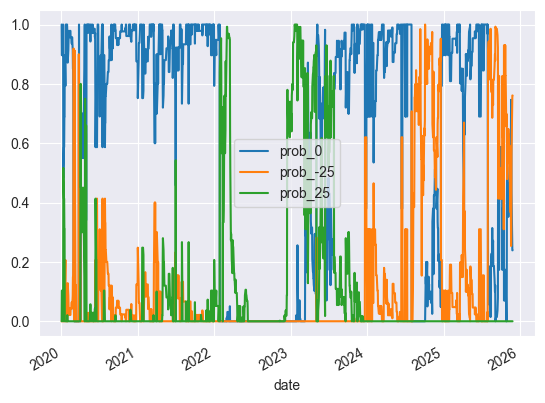

In [55]:
prob_series.loc['2020':,['prob_0','prob_-25','prob_25']].plot()

In [53]:
prob_series.to_excel('prob_series.xlsx')